In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [3]:
a2epath = '/home/equon/a2e-mmc'
if a2epath not in sys.path:
    sys.path.append(a2epath)
from mmctools.helper_functions import calc_wind, covariance
from mmctools.plotting import plot_timeheight, plot_profile, plot_timehistory_at_height

In [4]:
wtpath = os.environ['HOME']
if wtpath not in sys.path:
    sys.path.append(wtpath)
from windtools.openfoam import InputFile
from windtools.inflow.synthetic import TurbSim

pmap total memory usage: 4.297016 GB

# Read stochastic inflow from TurbSim and extract fluctuations
to use as boundary inflow perturbations

<font color='red'>Note</font>: This notebook has heavy resource usage and is better executed as a script. The tile operation has been commented out in cell 32 so that this notebook may be quickly run for demo purposes.

In [5]:
#
# mesoscale simulation (WRF) parameters
#
wrfstart = '2013-11-08 00:00'

# use same mean flow data as the internal-coupling approach:
driving_data = '/projects/mmc/dallaert/profile_assimilation_wrf/drivingData/fieldTable'

# PBL data from WRF
pbl_data = '/projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/wrf_d03_pbl.csv'

In [6]:
#
# coupled microscale simulation parameters
#
starttime = '2013-11-08 12:00'
endtime = '2013-11-09 12:00'

domain_height = 1000.0
domain_width = 5000.0
spacing = 10.0

In [7]:
#
# perturbation parameters
#
turbsim_prefix = '/projects/mmc/equon/turbsim/SWiFT_20131108_neutral'

halfthick = 50.0 # half-thickness of the layer transitioning from full perturbations to no perturbations
pert_freq = 10.0 # how often to add perturbations [s]

# reference values
zref = 74.7 # interpolate mesoscale data to this height
TIref = 0.10 # turbsim input [-]
Uref = 12.0 # turbsim input [m/s]
uuref = (Uref*TIref)**2

In [8]:
# observed variances from TTU (fro comparisons)
# - output from /home/equon/a2e-mmc/assessment/studies/coupling_comparison/TTU_coupling_comparison_day.ipynb
#ttu_data = None
ttu_data = '/home/equon/a2e-mmc/assessment/datasets/SWiFT/data/TTU_coupling_comparison_day.csv'

In [9]:
# outputs
outdir = '/projects/mmc/equon/turbsim/data'  # where to write out boundary data
animdir = '/projects/mmc/equon/turbsim/figures'
output_intervals = 3600 # [s], how much time to write per output file

## read velocity perturbation parameters

### mean flow data
Note: we would in general generate this from WRF data ourselves, but for the coupling comparison, let's reuse `fieldTable` generated by `assessment/studies/coupling_comparison/preprocessing/internal/wrf_to_sowfa.ipynb` for internal coupling.

In [10]:
fieldTable = InputFile(driving_data)
fieldTable

sourceHeightsMomentum : [list of length 401]
sourceTableMomentumX : [list of length 288]
sourceTableMomentumY : [list of length 288]
sourceTableMomentumZ : [list of length 288]
sourceHeightsTemperature : [list of length 401]
sourceTableTemperature : [list of length 288]

In [11]:
# assume velocity and temperature profiles were specified at the same heights
heights = np.array(fieldTable['sourceHeightsMomentum'])
heightsT = np.array(fieldTable['sourceHeightsTemperature'])
assert np.all(heights == heightsT)

In [12]:
U = np.array(fieldTable['sourceTableMomentumX'])
V = np.array(fieldTable['sourceTableMomentumY'])

In [13]:
times = U[:,0] # for some reason these weren't double precision
timesV = V[:,0]
assert np.all(times == timesV)

In [14]:
tindex = pd.Index(times.round(decimals=1), name='time')
columns = pd.MultiIndex.from_product((['u','v'], heights), names=[None,'height'])

In [15]:
# read WRF internal forcing drivingData
wrf_internal = pd.concat([pd.DataFrame(U[:,1:]),pd.DataFrame(V[:,1:])], axis=1).set_index(tindex)
wrf_internal.columns = columns
wrf_internal = wrf_internal.stack()

In [16]:
wrf_internal['wspd'],wrf_internal['wdir'] = calc_wind(wrf_internal)

Text(0.5, 1.0, 'WRF internal forcing driving data')

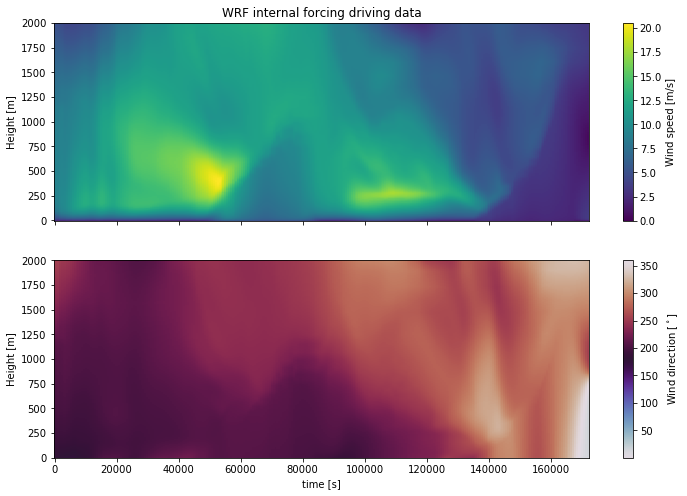

In [17]:
fig,ax,cbars = plot_timeheight(wrf_internal, fields=['wspd','wdir'])
ax[0].set_title('WRF internal forcing driving data')

In [18]:
# SOWFA start/end times
simstart = (pd.to_datetime(starttime) - pd.to_datetime(wrfstart)).total_seconds()
simend = (pd.to_datetime(endtime) - pd.to_datetime(wrfstart)).total_seconds()
simstart, simend

(43200.0, 129600.0)

Text(0.5, 1.0, 'WRF internal forcing (in surface layer)')

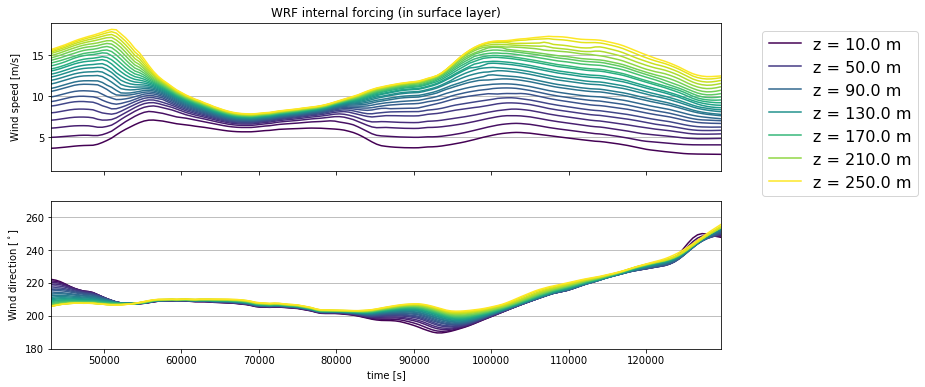

In [19]:
fig,ax = plot_timehistory_at_height(wrf_internal, fields=['wspd','wdir'],
                                    fieldlimits={'wdir':(180,270)},
                                    heights=np.arange(10,260,10),
                                    timelimits=(simstart,simend),
                                    cmap='viridis')
handles,labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::4], labels[::4],
             loc='upper left', bbox_to_anchor=(1.05,1), fontsize=16)
ax[0].set_title('WRF internal forcing (in surface layer)')

### get auxiliary WRF data (PBLH, TKE)
for scaling perturbations

Output is from `/projects/mmc/SWIFTRegion/extract_wrf_pbl_quantities.ipynb`


pmap total memory usage: 5.356096 GB

In [20]:
wrf = pd.read_csv(pbl_data,parse_dates=['Time'])
wrf

,Time,height,PBLH,TKE_PBL
0,2013-11-08 00:00:00,0.0,0.00000,0.0000
1,2013-11-08 00:00:00,5.0,0.00000,0.0000
2,2013-11-08 00:00:00,10.0,0.00000,0.0000
3,2013-11-08 00:00:00,15.0,0.00000,0.0000
4,2013-11-08 00:00:00,20.0,0.00000,0.0000
...,...,...,...,...
24456,2013-11-10 12:00:00,1980.0,88.03538,0.0005
24457,2013-11-10 12:00:00,1985.0,88.03538,0.0005
24458,2013-11-10 12:00:00,1990.0,88.03538,0.0005
24459,2013-11-10 12:00:00,1995.0,88.03538,0.0005


In [21]:
datacols = ['PBLH','TKE_PBL']

# trim times
inrange = (wrf['Time'] >= starttime) & (wrf['Time'] <= endtime)
wrf = wrf.loc[inrange]

# calculate simulation time where t=0 corresponds to the WRF start time
tdelta = wrf['Time'] - pd.to_datetime(starttime)
wrf['simtime'] = tdelta.dt.total_seconds()
wrf = wrf.set_index(['simtime','height'])[datacols]

wrf.head()

/home/equon/miniconda3/envs/forge/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


PBLH   TKE_PBL
simtime height                      
0.0     0.0     122.936745  0.234153
        5.0     122.936745  0.245271
        10.0    122.936745  0.249250
        15.0    122.936745  0.232938
        20.0    122.936745  0.215754

In [22]:
# select single height as reference for scaling the TKE
if zref not in wrf.index.levels[1]:
    unstacked = wrf.unstack(level=0)
    interpfun = interp1d(unstacked.index, unstacked, axis=0)
    unstacked.loc[zref] = interpfun(zref)
    wrf = unstacked.loc[zref].unstack(level=0)
else:
    wrf = wrf.xs(zref,level=1)

In [23]:
wrf

,PBLH,TKE_PBL
simtime,,
0.0,122.936745,0.085142
3600.0,124.136080,0.130715
7200.0,148.033570,0.477277
10800.0,351.705080,1.834503
14400.0,474.220670,1.991059
18000.0,464.030600,1.328484
21600.0,511.294950,1.251547
25200.0,640.920040,1.254937
28800.0,795.411100,1.303776


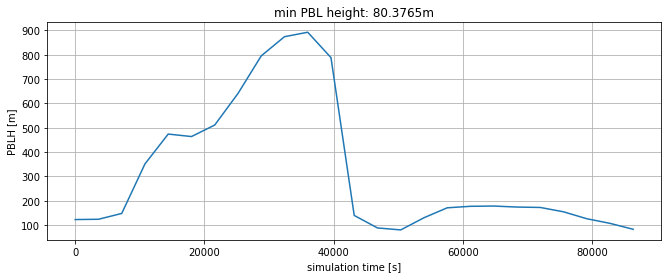

In [24]:
fig,ax = plt.subplots(figsize=(11,4))
ax.plot(wrf.index, wrf['PBLH'])
ax.set_title('min PBL height: {:g}m'.format(wrf['PBLH'].min()))
ax.set_xlabel('simulation time [s]')
ax.set_ylabel('PBLH [m]')
ax.grid(True)

TurbSim assumptions (from IEC):
- $\sigma_v = 0.8 \sigma_u$
- $\sigma_w = 0.5 \sigma_u$

$k = \frac{1}{2}\left( \langle u'u' \rangle + \langle v'v' \rangle + \langle w'w' \rangle \right)
   = \frac{1}{2}\left[ (1^2 + 0.8^2 + 0.5^2) \langle u'u' \rangle \right]$

In [25]:
# estimate streamwise variance from PBL parameterization
wrf['uu'] = 2 / 1.89 * wrf['TKE_PBL']

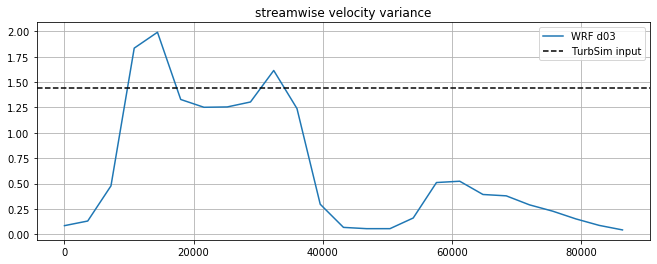

In [26]:
fig,ax = plt.subplots(figsize=(11,4))
ax.plot(wrf.index, wrf['TKE_PBL'])
ax.axhline(uuref, color='k', ls='--',label='TurbSim')
ax.set_title('streamwise velocity variance')
ax.legend(ax.get_lines(),['WRF d03','TurbSim input'])
ax.grid(True)

### combine time-varying perturbation parameters
resample to perturbation frequency here

pmap total memory usage: 9.944792 GB

In [27]:
# calculate timedelta
ref = wrf.reset_index()
ref['timedelta'] = pd.to_timedelta(ref['simtime'],unit='s')

# upsample to perturbation frequency
ref = ref.set_index('timedelta').resample('{:g}s'.format(pert_freq)).interpolate(method='index')

# round off simulation times so we don't have trouble identifying the turbsim inflow plane indices later
ref['simtime'] = np.round(ref['simtime'], decimals=2)
ref = ref.set_index('simtime')
Ntimes = len(ref)

ref

,PBLH,TKE_PBL,uu
simtime,,,
0.0,122.936745,0.085142,0.090098
10.0,122.940076,0.085269,0.090232
20.0,122.943408,0.085395,0.090366
30.0,122.946739,0.085522,0.090500
40.0,122.950071,0.085649,0.090633
...,...,...,...
86360.0,83.170840,0.043575,0.046111
86370.0,83.102862,0.043451,0.045980
86380.0,83.034885,0.043327,0.045849


In [28]:
# add wind direction from internal forcing drivingData
wdir = wrf_internal['wdir'].unstack(level=0)

# - interpolate to zref
wdir.loc[zref] = interp1d(wdir.index, wdir, axis=0)(zref)
wdir = wdir.loc[zref]

# - select times within simulation range
inrange = (wdir.index >= simstart) & (wdir.index <= simend)
wdir = wdir.loc[inrange] # result is a series

# - convert to simtime and resample
wdir.index = pd.to_timedelta(wdir.index-simstart,unit='s')
ref['wdir'] = wdir.resample('{:g}s'.format(pert_freq)).interpolate(method='index').values

In [29]:
ref['vv'] = np.nan
ref['ww'] = np.nan

### read TTU data for comparison (optional)

pmap total memory usage: 9.953896 GB

In [30]:
if ttu_data is not None:
    ttu = pd.read_csv(ttu_data,parse_dates=['datetime'])#.set_index(['datetime','height'])
    ttu['simtime'] = (ttu['datetime'] - pd.to_datetime(starttime)).dt.total_seconds()
    ttu = ttu.set_index(['simtime','height'])

In [31]:
ttu

datetime          u         v         w          Ts  \
simtime height                                                                  
0.0     0.9    2013-11-08 12:00:00   0.771536  0.951881 -0.018282  276.334850   
        2.4    2013-11-08 12:00:00   1.260950  1.245333  0.030045  278.355767   
        4.0    2013-11-08 12:00:00   1.551049  1.335392 -0.063838  275.928133   
        10.1   2013-11-08 12:00:00   2.403286  1.760255 -0.057057  275.504850   
        16.8   2013-11-08 12:00:00   3.382121  2.030124 -0.025369  276.339683   
...                            ...        ...       ...       ...         ...   
86400.0 47.3   2013-11-09 12:00:00   3.615797  4.533495 -0.152443  283.050000   
        74.7   2013-11-09 12:00:00   4.684826  5.379314 -0.060634  283.650000   
        116.5  2013-11-09 12:00:00   4.994392  4.669043  0.022001  282.390000   
        158.2  2013-11-09 12:00:00  10.170214  6.882949 -1.205570  284.180000   
        200.0  2013-11-09 12:00:00  11.300175  3.385397  0.028638  287.570000   

                         T         RH           p       wspd        wdir  \
simtime height                                                             
0.0     0.9     273.212250  65.766230  905.413743   1.225294  219.026117   
        2.4     273.747200  63.121640  905.590278   1.772244  225.357000   
        4.0     274.227238  60.996327  905.043079   2.046711  229.272852   
        10.1    275.140847  56.969527  904.410899   2.978974  233.779580   
        16.8    275.711010  53.643827  904.002881   3.944635  239.025638   
...                    ...        ...         ...        ...         ...   
86400.0 47.3    278.698000  99.926000  892.071563   5.798842  218.574947   
        74.7    278.748000  98.278000  889.819607   7.133346  221.052496   
        116.5   278.336000  99.920000  885.287588   6.836952  226.928306   
        158.2   279.848000  99.932010  881.007517  12.280400  235.910833   
        200.0   283.690000  66.304000  876.063373  11.796392  253.322417   

                      TI        uu        vv        ww        uw        vw  \
simtime height                                                               
0.0     0.9     0.119743  0.027393  0.019594  0.010080 -0.003451 -0.004300   
        2.4     0.093080  0.040872  0.016331  0.008022 -0.004545 -0.002682   
        4.0     0.083511  0.038707  0.015182  0.007573 -0.003932 -0.001607   
        10.1    0.050759  0.028247  0.015618  0.005741 -0.000997 -0.000757   
        16.8    0.043231  0.021806  0.022396  0.004048 -0.002495 -0.001631   
...                  ...       ...       ...       ...       ...       ...   
86400.0 47.3         NaN       NaN       NaN       NaN  0.000000  0.000000   
        74.7         NaN       NaN       NaN       NaN  0.000000  0.000000   
        116.5        NaN       NaN       NaN       NaN  0.000000  0.000000   
        158.2        NaN       NaN       NaN       NaN  0.000000  0.000000   
        200.0        NaN       NaN       NaN       NaN  0.000000  0.000000   

                     thw       TKE        u*  
simtime height                                
0.0     0.9    -0.007913  0.028534  0.074255  
        2.4    -0.006403  0.032612  0.072641  
        4.0    -0.004315  0.030731  0.065173  
        10.1   -0.001185  0.024803  0.035385  
        16.8   -0.002767  0.024125  0.054594  
...                  ...       ...       ...  
86400.0 47.3    0.000000       NaN  0.000000  
        74.7    0.000000       NaN  0.000000  
        116.5   0.000000       NaN  0.000000  
        158.2   0.000000       NaN  0.000000  
        200.0   0.000000       NaN  0.000000  

[1450 rows x 19 columns]

## now, read binary TurbSim output

pmap total memory used: 9.945052 GB

In [32]:
%%time
ts = TurbSim(turbsim_prefix, verbose=True)

# # tile the domain (TODO: uncomment this section)
# ts_width = np.max(ts.y) - np.min(ts.y)
# ntiles = int(np.ceil(domain_width / ts_width))
# print(ntiles,'tiles needed for simulated inflow plane width of',ts_width)
# ts.tileY(ntiles=ntiles, mirror=True)

# 1 km x 1 km:
# CPU times: user 4min 22s, sys: 627 ms, total: 4min 23s
# Wall time: 4min 24s

Reading header information from /projects/mmc/equon/turbsim/SWiFT_20131108_neutral.bts
  id= 8 (periodic)
  NumGrid_Z,_Y= 101 101
  ntower= 0
  nt= 12096
  (problem size: 370173888 points)
  dz,dy= 10.0 10.0
  TimeStep= 0.05
  Period= 604.8
  Umean = uhub = 12.0 (for calculating fluctuations)
  HubHt= 501.0  (NOT USED)
  Zbottom= 1.0
  Vslope= [5234.304  6653.7617 9680.994 ]
  Vintercept= [-63909.46       291.46875  -1513.0137 ]
b'This full-field file was generated by TurbSim on 24-Oct-2019 at 15:47:42.'
Reading normalized grid data
  U size : 1412.101318359375 MB
  Read velocitiy fields in 277.49 s
Calculating velocities from normalized data
  u min/max [ -6.050506 6.469782 ]
  v min/max [ -4.9685383 4.880778 ]
  w min/max [ -3.2284894 3.5409603 ]
Calculating coordinates
Read times [ 0.0 0.05 ... 604.75 ]
CPU times: user 4min 39s, sys: 815 ms, total: 4min 40s
Wall time: 4min 41s


pmap total memory used: 29.076840 GB

In [33]:
%%time
# calculate reference variances from turbsim, should be close to input TI
uu_sim = np.mean(np.var(ts.U[0,:,:,:],axis=0))
vv_sim = np.mean(np.var(ts.U[1,:,:,:],axis=0))
ww_sim = np.mean(np.var(ts.U[2,:,:,:],axis=0))

# CPU times: user 6.99 s, sys: 2.27 s, total: 9.27 s
# Wall time: 9.29 s

CPU times: user 1.69 s, sys: 292 ms, total: 1.98 s
Wall time: 1.99 s


## rotate variances

In [34]:
# calculate a reference variances in the wind frame (in which u is aligned with the wind)
windangle = np.radians(270 - ref['wdir'])
uu_sim_rotated = uu_sim*np.cos(windangle)**2 + vv_sim*np.sin(windangle)**2
vv_sim_rotated = uu_sim*np.sin(windangle)**2 + vv_sim*np.cos(windangle)**2

Text(0.5, 1.0, 'before rescaling')

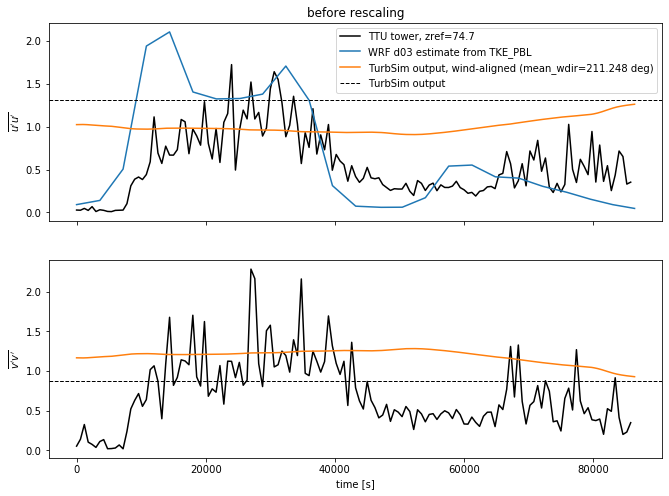

In [35]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))
ttu['uu'].xs(zref,level='height').plot(ax=ax[0],color='k',label='TTU tower, zref={:g}'.format(zref))
ref['uu'].plot(ax=ax[0],label='WRF d03 estimate from TKE_PBL')
ttu['vv'].xs(zref,level='height').plot(ax=ax[1],color='k')
ref['vv'].plot(ax=ax[1])
uu_sim_rotated.plot(ax=ax[0],
                    label='TurbSim output, wind-aligned (mean_wdir={:g} deg)'.format(np.mean(ref['wdir'])))
vv_sim_rotated.plot(ax=ax[1])
ax[0].axhline(uu_sim, color='k', ls='--', lw=1, label='TurbSim output')
ax[1].axhline(vv_sim, color='k', ls='--', lw=1)
ax[0].legend()
ax[0].set_ylabel(r"$\overline{u'u'}$")
ax[1].set_ylabel(r"$\overline{v'v'}$")
ax[-1].set_xlabel('time [s]')
ax[0].set_title('before rescaling')

## map simulation times to turbsim times
Note: Using `period` not a multiple of the sampling frequency, introduces more samples into the perturbations.

In [36]:
period = np.round(np.float64(ts.period), decimals=2)
dt = np.round(np.float64(ts.dt), decimals=2)
print(period)

604.8


In [37]:
ref['turbsim_time'] = ref.index % period
ref['turbsim_time'] = ref['turbsim_time'].round(2) # round to 2 decimals

In [38]:
ref['turbsim_index'] = (ref['turbsim_time'] / dt).round().astype(int)
# make sure indices in range!
assert np.all(ref['turbsim_index'] < ts.N)
# make sure we recover the expected simulation time!
assert np.max(np.abs(ref['turbsim_index']*dt - ref['turbsim_time'])) < 1e-12

In [39]:
uniqueidx = np.unique(ref['turbsim_index'])
print('{:d} unique samples: {:s}'.format(len(uniqueidx), str(uniqueidx)))

1512 unique samples: [    0     8    16 ... 12072 12080 12088]


## calculate scaling for fluctuations

In [40]:
# inverse tangent function to smoothly transition fluctuations to 0 above the ABL
k = np.arctanh(0.8) / halfthick # == np.arctanh(0.8) / (tanh_z90-tanh_z50)

def cappingfun(zi):
    return 0.5*(np.tanh(-k*(ts.z-zi)) + 1.0)

# def get_scaling(zi, uu_tgt, vv_tgt, ww_tgt, uu_rot_ref, vv_rot_ref):
#     """independent scaling of u/v/w"""
#     uscale = np.sqrt(uu_tgt / uu_rot_ref) * cappingfun(zi)
#     vscale = np.sqrt(vv_tgt / vv_rot_ref) * cappingfun(zi)
#     wscale = np.sqrt(ww_tgt / ww_ref) * cappingfun(zi)

In [41]:
# %%time
# """Scale variances separately for u/v/w components"""
# uscale = np.zeros((Ntimes,ts.NZ))
# vscale = np.zeros((Ntimes,ts.NZ))
# wscale = np.zeros((Ntimes,ts.NZ))
# for itime,(tstamp,state) in enumerate(ref.iterrows()):
#     #print(simtime[itime],tstamp)
#     uscale[itime,:], vscale[itime,:], wscale[itime,:] = get_scaling(state['PBLH'],
#                                                                     state['uu'],
#                                                                     state['vv'],
#                                                                     state['ww'],
#                                                                     uu_ref_rotated.loc[tstamp],
#                                                                     vv_ref_rotated.loc[tstamp])
# CPU times: user 1.07 s, sys: 3.88 ms, total: 1.07 s
# Wall time: 1.07 s

In [42]:
%%time
"""Scale variances uniformly"""
uscale = np.zeros((Ntimes,ts.NZ)) #  to be applied to the fluctuations
for itime,(tstamp,state) in enumerate(ref.iterrows()):
    # note: ref['uu'] is the estimated streamwise variance
    uscale[itime,:] = np.sqrt(state['uu'] / uu_sim_rotated.loc[tstamp]) * cappingfun(state['PBLH'])

CPU times: user 1 s, sys: 5.01 ms, total: 1.01 s
Wall time: 1.01 s


In [43]:
# set up dataframe for plot
scaling = pd.DataFrame(uscale,index=ref.index,columns=ts.z).stack()
scaling.index.set_names(['time','height'], inplace=True)

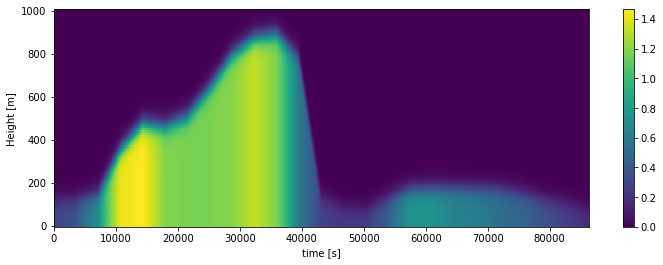

In [44]:
fig,ax,cbars = plot_timeheight(scaling)

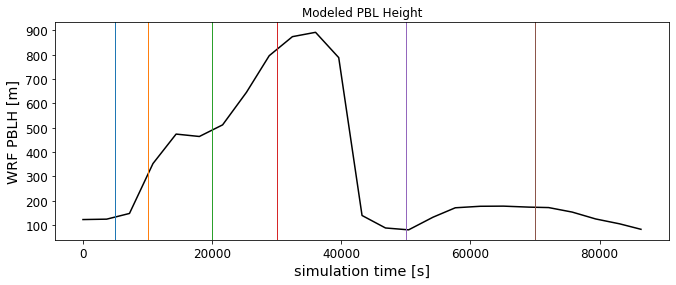

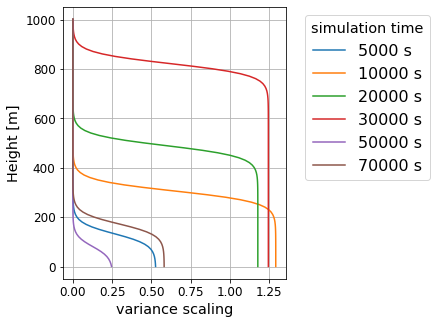

In [45]:
# sanity check for scaling functions
selectedtimes = [5000,10000,20000,30000,50000,70000]

fig,ax = plt.subplots(figsize=(11,4))
ax.plot(ref.index, ref['PBLH'], 'k')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,ti in enumerate(selectedtimes):
    ax.axvline(ti,color=colors[i],lw=1)
ax.set_title('Modeled PBL Height')
ax.set_xlabel('simulation time [s]',fontsize='x-large')
ax.set_ylabel('WRF PBLH [m]',fontsize='x-large')
ax.tick_params(labelsize='large')

fig,ax = plot_profile(scaling,times=selectedtimes)
ax.set_xlabel('variance scaling')
ax.tick_params(labelsize='large')
ax.xaxis.label.set_size('x-large')
ax.yaxis.label.set_size('x-large')
lgd = ax.get_legend()
lgd.set_title('simulation time')
lgd.get_title().set_fontsize('x-large')

## calculate fluctuation field
and save into array for simple export to matlab for WRF offline coupling

In [46]:
%%time
u = np.empty((Ntimes, ts.NY, ts.NZ))
v = np.empty((Ntimes, ts.NY, ts.NZ))
w = np.empty((Ntimes, ts.NY, ts.NZ))
for itime,(simtime,state) in enumerate(ref.iterrows()):
    iplane = int(state['turbsim_index'])
    ang = windangle.loc[simtime] # mean wind angle at ref height, ang(t)
    profile = scaling.xs(simtime,level=0) # scaling profile, f(t,z)
    
    # at itime, calculate inflow fluctuations as the rotated turbsim inflow, scaled by the assumed profile
    u[itime,:,:] = profile[np.newaxis,:] * (ts.U[0,iplane,:,:]*np.cos(ang) - ts.U[1,iplane,:,:]*np.sin(ang))
    v[itime,:,:] = profile[np.newaxis,:] * (ts.U[0,iplane,:,:]*np.sin(ang) + ts.U[1,iplane,:,:]*np.cos(ang))
    w[itime,:,:] = profile[np.newaxis,:] *  ts.U[2,iplane,:,:]

# CPU times: user 9.92 s, sys: 3.25 s, total: 13.2 s
# Wall time: 13.2 s   

CPU times: user 13.5 s, sys: 469 ms, total: 13.9 s
Wall time: 14 s


In [47]:
# reshape for 2D output
udf = pd.DataFrame(data=u.reshape((Ntimes,ts.NY*ts.NZ),order='C'),
                   index=ref.index)
vdf = pd.DataFrame(data=v.reshape((Ntimes,ts.NY*ts.NZ),order='C'),
                   index=ref.index)
wdf = pd.DataFrame(data=w.reshape((Ntimes,ts.NY*ts.NZ),order='C'),
                   index=ref.index)

In [48]:
yy,zz = np.meshgrid(ts.y,ts.z,indexing='ij')

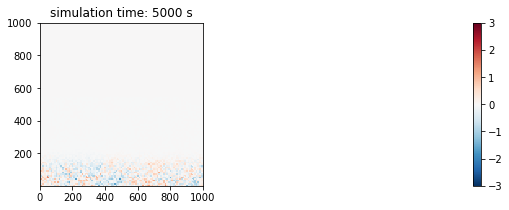

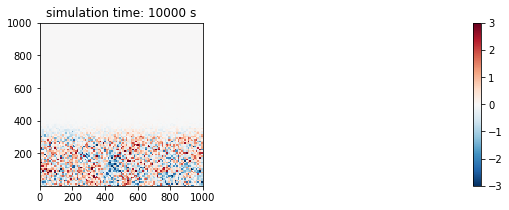

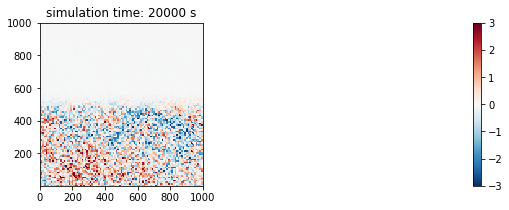

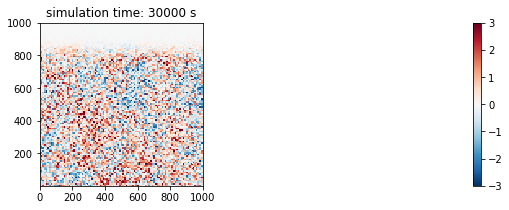

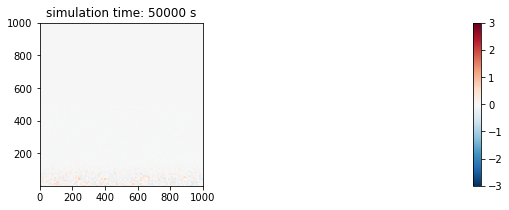

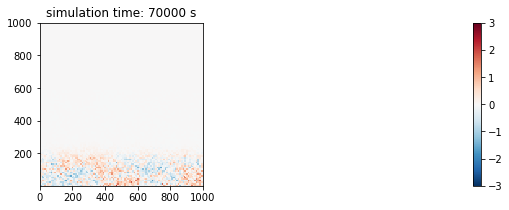

In [49]:
for simtime in selectedtimes:
    rowdata = udf.loc[simtime]
    fig,ax = plt.subplots(figsize=(14,3))
    tmp = rowdata.values.reshape((ts.NY,ts.NZ),order='C')
    pcm = ax.pcolormesh(yy,zz,tmp,cmap='RdBu_r',vmin=-3,vmax=3)
    cbar = plt.colorbar(pcm)
    ax.set_title('simulation time: {:g} s'.format(simtime))
    ax.axis('scaled')

In [50]:
# %%time
# #fig,ax = plt.subplots(nrows=3,sharex=True,figsize=(14,11))
# fig = plt.figure(constrained_layout=True,figsize=(14,11))
# gs = fig.add_gridspec(4,3)

# # inflow plane u/v/w
# ax = [fig.add_subplot(gs[i,:]) for i in range(3)]
# pcm = []
# cbar = []
# zeroes = np.zeros((ts.NY-1,ts.NZ-1))
# for i in range(3):
#     pcm.append(ax[i].pcolormesh(yy,zz,zeroes,cmap='RdBu_r',vmin=-3,vmax=3))
#     cbar.append(fig.colorbar(pcm[i], ax=ax[i]))
# cbar[0].set_label("u' [m/s]", fontsize='x-large')
# cbar[1].set_label("v' [m/s]", fontsize='x-large')
# cbar[2].set_label("w' [m/s]", fontsize='x-large')
# ax[0].set_ylabel('z [m]')
# ax[1].set_ylabel('z [m]')
# ax[2].set_ylabel('z [m]')
# ax[-1].set_xlabel('x or y [m]')

# # WRF reference plots
# timeindicator = []
# ax_wdir = fig.add_subplot(gs[3,0])
# ax_wdir.plot(ref.index, ref['wdir'])
# ax_wdir.set_xlabel('simulation time [s]')
# ax_wdir.set_ylabel('WRF (d03) wind dir [deg]')
# ax_wdir.set_xticks(np.arange(0,86401,6*3600))
# timeindicator.append(ax_wdir.axvline(0,color=[0,1,0],lw=1))

# ax_pblh = fig.add_subplot(gs[3,1])
# ax_pblh.plot(ref.index, ref['PBLH'])
# ax_pblh.set_xlabel('simulation time [s]')
# ax_pblh.set_ylabel('WRF (d03) PBLH [m]')
# ax_pblh.set_xticks(np.arange(0,86401,6*3600))
# timeindicator.append(ax_pblh.axvline(0,color=[0,1,0],lw=1))

# ax_tke = fig.add_subplot(gs[3,2])
# ax_tke.plot(ref.index, ref['TKE_PBL'])
# ax_tke.set_xlabel('simulation time [s]')
# ax_tke.set_ylabel(r'WRF (d03) TKE [m$^2$/s$^2$]')
# ax_tke.set_xticks(np.arange(0,86401,6*3600))
# timeindicator.append(ax_tke.axvline(0,color=[0,1,0],lw=1))

# def plot_inflow_at_time(simtime):
#     ax[0].set_title('{:g} s from {:s}'.format(simtime,starttime), fontsize='x-large')
#     rowdata = udf.loc[simtime]
#     tmp = rowdata.values.reshape((ts.NY,ts.NZ),order='C')
#     pcm[0].set_array(tmp[:-1,:-1].ravel())
#     rowdata = vdf.loc[simtime]
#     tmp = rowdata.values.reshape((ts.NY,ts.NZ),order='C')
#     pcm[1].set_array(tmp[:-1,:-1].ravel())
#     rowdata = wdf.loc[simtime]
#     tmp = rowdata.values.reshape((ts.NY,ts.NZ),order='C')
#     pcm[2].set_array(tmp[:-1,:-1].ravel())
#     for timeind in timeindicator:
#         timeind.set_data([simtime,simtime],[0,1])

# if not os.path.isdir(animdir):
#     os.makedirs(animdir)
# for simtime in ref.index[::6]:
#     fpath = os.path.join(animdir,'turbsim_inflow_{:06d}.png'.format(int(simtime)))
#     sys.stdout.write('\rGenerating {:s}'.format(fpath))
#     plot_inflow_at_time(simtime)
#     fig.savefig(fpath, dpi=150, bbox_inches='tight')

# 300 DPI: 
# CPU times: user 56min 14s, sys: 8min 57s, total: 1h 5min 12s
# Wall time: 55min 47s

### write output for WRF offline coupling

In [ ]:
# output at cell centers
yout = ts.y + spacing/2
zout = ts.z - ts.z[0] + spacing/2

In [ ]:
if not os.path.isdir(outdir):
    os.makedirs(outdir)

In [ ]:
with open(os.path.join(outdir,'y'), 'w') as f:
    np.savetxt(f, yout, fmt='%g')

In [ ]:
with open(os.path.join(outdir,'z'), 'w') as f:
    np.savetxt(f, zout, fmt='%g')

In [ ]:
assert np.all(udf.index == vdf.index)
assert np.all(udf.index == wdf.index)
assert np.all(vdf.index == wdf.index)

In [ ]:
%%time
for t1 in np.arange(0,ref.index[-1],output_intervals):
    ufile = os.path.join(outdir,'u_{:05d}.csv.gz'.format(int(t1)))
    vfile = os.path.join(outdir,'v_{:05d}.csv.gz'.format(int(t1)))
    wfile = os.path.join(outdir,'w_{:05d}.csv.gz'.format(int(t1)))
    outputrange = (udf.index >= t1) & (udf.index < t1+output_intervals)
    udf.loc[outputrange].to_csv(ufile, header=False, compression='gzip')
    print('Wrote',ufile)
    vdf.loc[outputrange].to_csv(vfile, header=False, compression='gzip')
    print('Wrote',vfile)
    wdf.loc[outputrange].to_csv(wfile, header=False, compression='gzip')
    print('Wrote',wfile)

# CPU times: user 1h 27min 19s, sys: 1min 2s, total: 1h 28min 21s
# Wall time: 1h 28min 41s